In [1]:
import timm 
from timm.models import registry
#from SegFunctions import *
import echonet
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import math
import os
import time
import torch.optim as optim
import click
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import skimage.draw
import torchvision
import tqdm

m = 'swin_tiny_patch4_window7_224'
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Using device: cuda


In [2]:
def run_segmentation(
    data_dir=None,
    output=None,

    model_name="deeplabv3_resnet50",
    model = None,
    pretrained=False,
    weights=None,

    run_test=False,
    save_video=False,
    num_epochs=50,
    lr=1e-5,
    weight_decay=1e-5,
    lr_step_period=None,
    num_train_patients=None,
    num_workers=4,
    batch_size=20,
    device=None,
    seed=0,
    target_transform = None,
):
    """Trains/tests segmentation model.

    Args:
        data_dir (str, optional): Directory containing dataset. Defaults to
            `echonet.config.DATA_DIR`.
        output (str, optional): Directory to place outputs. Defaults to
            output/segmentation/<model_name>_<pretrained/random>/.
        model_name (str, optional): Name of segmentation model. One of ``deeplabv3_resnet50'',
            ``deeplabv3_resnet101'', ``fcn_resnet50'', or ``fcn_resnet101''
            (options are torchvision.models.segmentation.<model_name>)
            Defaults to ``deeplabv3_resnet50''.
        model (str, optional): Name of model from timm library. Defaults to None.
        pretrained (bool, optional): Whether to use pretrained weights for model
            Defaults to False.
        weights (str, optional): Path to checkpoint containing weights to
            initialize model. Defaults to None.
        run_test (bool, optional): Whether or not to run on test.
            Defaults to False.
        save_video (bool, optional): Whether to save videos with segmentations.
            Defaults to False.
        num_epochs (int, optional): Number of epochs during training
            Defaults to 50.
        lr (float, optional): Learning rate for SGD
            Defaults to 1e-5.
        weight_decay (float, optional): Weight decay for SGD
            Defaults to 0.
        lr_step_period (int or None, optional): Period of learning rate decay
            (learning rate is decayed by a multiplicative factor of 0.1)
            Defaults to math.inf (never decay learning rate).
        num_train_patients (int or None, optional): Number of training patients
            for ablations. Defaults to all patients.
        num_workers (int, optional): Number of subprocesses to use for data
            loading. If 0, the data will be loaded in the main process.
            Defaults to 4.
        device (str or None, optional): Name of device to run on. Options from
            https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device
            Defaults to ``cuda'' if available, and ``cpu'' otherwise.
        batch_size (int, optional): Number of samples to load per batch
            Defaults to 20.
        seed (int, optional): Seed for random number generator. Defaults to 0.
    """

    # Seed RNGs
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Set default output directory
    if output is None:
        output = os.path.join("output", "segmentation", "{}_{}".format(model_name, "pretrained" if pretrained else "random"))
    os.makedirs(output, exist_ok=True)

    # Set device for computations
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set up model
    if model is None:
        model = torchvision.models.segmentation.__dict__[model_name](pretrained=pretrained, aux_loss=False)
        model.classifier[-1] = torch.nn.Conv2d(model.classifier[-1].in_channels, 1, kernel_size=model.classifier[-1].kernel_size)  # change number of outputs to 1
    else:
        model = model
    
    if device.type == "cuda":
        model = torch.nn.DataParallel(model)
    model.to(device)

    if weights is not None:
        checkpoint = torch.load(weights)
        model.load_state_dict(checkpoint['state_dict'])

    # Set up optimizer
    #optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    if lr_step_period is None:
        lr_step_period = math.inf
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_period)

    # Compute mean and std
    mean, std = echonet.utils.get_mean_and_std(echonet.datasets.Echo(root=data_dir, split="train"))
    tasks = ["LargeFrame", "SmallFrame", "LargeTrace", "SmallTrace"]
    kwargs = {"target_type": tasks,
              "mean": mean,
              "std": std
              }

    # Set up datasets and dataloaders
    dataset = {}
    dataset["train"] = echonet.datasets.Echo(root=data_dir, split="train", **kwargs)
    if num_train_patients is not None and len(dataset["train"]) > num_train_patients:
        # Subsample patients (used for ablation experiment)
        indices = np.random.choice(len(dataset["train"]), num_train_patients, replace=False)
        dataset["train"] = torch.utils.data.Subset(dataset["train"], indices)
    dataset["val"] = echonet.datasets.Echo(root=data_dir, split="val", **kwargs)

    # Run training and testing loops
    with open(os.path.join(output, "log.csv"), "a") as f:
        epoch_resume = 0
        bestLoss = float("inf")
        try:
            # Attempt to load checkpoint
            checkpoint = torch.load(os.path.join(output, "checkpoint.pt"))
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['opt_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_dict'])
            epoch_resume = checkpoint["epoch"] + 1
            bestLoss = checkpoint["best_loss"]
            f.write("Resuming from epoch {}\n".format(epoch_resume))
        except FileNotFoundError:
            f.write("Starting run from scratch\n")

        for epoch in range(epoch_resume, num_epochs):
            print("Epoch #{}".format(epoch), flush=True)
            for phase in ['train', 'val']:
                start_time = time.time()
                for i in range(torch.cuda.device_count()):
                    torch.cuda.reset_peak_memory_stats(i)

                ds = dataset[phase]
                dataloader = torch.utils.data.DataLoader(
                    ds, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=(device.type == "cuda"), drop_last=(phase == "train"))

                loss, large_inter, large_union, small_inter, small_union = echonet.utils.segmentation.run_epoch(model, dataloader, phase == "train", optimizer, device)
                overall_dice = 2 * (large_inter.sum() + small_inter.sum()) / (large_union.sum() + large_inter.sum() + small_union.sum() + small_inter.sum())
                large_dice = 2 * large_inter.sum() / (large_union.sum() + large_inter.sum())
                small_dice = 2 * small_inter.sum() / (small_union.sum() + small_inter.sum())
                f.write("{},{},{},{},{},{},{},{},{},{},{}\n".format(epoch,
                                                                    phase,
                                                                    loss,
                                                                    overall_dice,
                                                                    large_dice,
                                                                    small_dice,
                                                                    time.time() - start_time,
                                                                    large_inter.size,
                                                                    sum(torch.cuda.max_memory_allocated() for i in range(torch.cuda.device_count())),
                                                                    sum(torch.cuda.max_memory_reserved() for i in range(torch.cuda.device_count())),
                                                                    batch_size))
                f.flush()
            scheduler.step()

            # Save checkpoint
            save = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'best_loss': bestLoss,
                'loss': loss,
                'opt_dict': optimizer.state_dict(),
                'scheduler_dict': scheduler.state_dict(),
            }
            torch.save(save, os.path.join(output, "checkpoint.pt"))
            if loss < bestLoss:
                torch.save(save, os.path.join(output, "best.pt"))
                bestLoss = loss

        # Load best weights
        if num_epochs != 0:
            checkpoint = torch.load(os.path.join(output, "best.pt"))
            model.load_state_dict(checkpoint['state_dict'])
            f.write("Best validation loss {} from epoch {}\n".format(checkpoint["loss"], checkpoint["epoch"]))

        if run_test:
            # Run on validation and test
            for split in ["val", "test"]:
                dataset = echonet.datasets.Echo(root=data_dir, split=split, **kwargs)
                dataloader = torch.utils.data.DataLoader(dataset,
                                                         batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=(device.type == "cuda"))
                loss, large_inter, large_union, small_inter, small_union = echonet.utils.segmentation.run_epoch(model, dataloader, False, None, device)

                overall_dice = 2 * (large_inter + small_inter) / (large_union + large_inter + small_union + small_inter)
                large_dice = 2 * large_inter / (large_union + large_inter)
                small_dice = 2 * small_inter / (small_union + small_inter)
                with open(os.path.join(output, "{}_dice.csv".format(split)), "w") as g:
                    g.write("Filename, Overall, Large, Small\n")
                    for (filename, overall, large, small) in zip(dataset.fnames, overall_dice, large_dice, small_dice):
                        g.write("{},{},{},{}\n".format(filename, overall, large, small))

                f.write("{} dice (overall): {:.4f} ({:.4f} - {:.4f})\n".format(split, *echonet.utils.bootstrap(np.concatenate((large_inter, small_inter)), np.concatenate((large_union, small_union)), echonet.utils.dice_similarity_coefficient)))
                f.write("{} dice (large):   {:.4f} ({:.4f} - {:.4f})\n".format(split, *echonet.utils.bootstrap(large_inter, large_union, echonet.utils.dice_similarity_coefficient)))
                f.write("{} dice (small):   {:.4f} ({:.4f} - {:.4f})\n".format(split, *echonet.utils.bootstrap(small_inter, small_union, echonet.utils.dice_similarity_coefficient)))
                f.flush()

    # Saving videos with segmentations
    dataset = echonet.datasets.Echo(root=data_dir, split="test",
                                    target_type=["Filename", "LargeIndex", "SmallIndex"],  # Need filename for saving, and human-selected frames to annotate
                                    mean=mean, std=std,  # Normalization
                                    length=None, max_length=None, period=1  # Take all frames
                                    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=num_workers, shuffle=False, pin_memory=False, collate_fn=echonet.utils.segmentation._video_collate_fn)

    # Save videos with segmentation
    if save_video and not all(os.path.isfile(os.path.join(output, "videos", f)) for f in dataloader.dataset.fnames):
        # Only run if missing videos

        model.eval()

        os.makedirs(os.path.join(output, "videos"), exist_ok=True)
        os.makedirs(os.path.join(output, "size"), exist_ok=True)
        echonet.utils.latexify()

        with torch.no_grad():
            with open(os.path.join(output, "size.csv"), "w") as g:
                g.write("Filename,Frame,Size,HumanLarge,HumanSmall,ComputerSmall\n")
                for (x, (filenames, large_index, small_index), length) in tqdm.tqdm(dataloader):
                    # Run segmentation model on blocks of frames one-by-one
                    # The whole concatenated video may be too long to run together
                    try:
                        y = np.concatenate([model(x[i:(i + batch_size), :, :, :].to(device))["out"].detach().cpu().numpy() for i in range(0, x.shape[0], batch_size)])
                    except:
                        y = np.concatenate([model(x[i:(i + batch_size), :, :, :].to(device)).detach().cpu().numpy() for i in range(0, x.shape[0], batch_size)])

                    start = 0
                    x = x.numpy()
                    for (i, (filename, offset)) in enumerate(zip(filenames, length)):
                        # Extract one video and segmentation predictions
                        video = x[start:(start + offset), ...]
                        logit = y[start:(start + offset), 0, :, :]

                        # Un-normalize video
                        video *= std.reshape(1, 3, 1, 1)
                        video += mean.reshape(1, 3, 1, 1)

                        # Get frames, channels, height, and width
                        f, c, h, w = video.shape  # pylint: disable=W0612
                        assert c == 3

                        # Put two copies of the video side by side
                        video = np.concatenate((video, video), 3)

                        # If a pixel is in the segmentation, saturate blue channel
                        # Leave alone otherwise
                        video[:, 0, :, w:] = np.maximum(255. * (logit > 0), video[:, 0, :, w:])  # pylint: disable=E1111

                        # Add blank canvas under pair of videos
                        video = np.concatenate((video, np.zeros_like(video)), 2)

                        # Compute size of segmentation per frame
                        size = (logit > 0).sum((1, 2))

                        # Identify systole frames with peak detection
                        trim_min = sorted(size)[round(len(size) ** 0.05)]
                        trim_max = sorted(size)[round(len(size) ** 0.95)]
                        trim_range = trim_max - trim_min
                        systole = set(scipy.signal.find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0])

                        # Write sizes and frames to file
                        for (frame, s) in enumerate(size):
                            g.write("{},{},{},{},{},{}\n".format(filename, frame, s, 1 if frame == large_index[i] else 0, 1 if frame == small_index[i] else 0, 1 if frame in systole else 0))

                        # Plot sizes
                        fig = plt.figure(figsize=(size.shape[0] / 50 * 1.5, 3))
                        plt.scatter(np.arange(size.shape[0]) / 50, size, s=1)
                        ylim = plt.ylim()
                        for s in systole:
                            plt.plot(np.array([s, s]) / 50, ylim, linewidth=1)
                        plt.ylim(ylim)
                        plt.title(os.path.splitext(filename)[0])
                        plt.xlabel("Seconds")
                        plt.ylabel("Size (pixels)")
                        plt.tight_layout()
                        plt.savefig(os.path.join(output, "size", os.path.splitext(filename)[0] + ".pdf"))
                        plt.close(fig)

                        # Normalize size to [0, 1]
                        size -= size.min()
                        size = size / size.max()
                        size = 1 - size

                        # Iterate the frames in this video
                        for (f, s) in enumerate(size):

                            # On all frames, mark a pixel for the size of the frame
                            video[:, :, int(round(115 + 100 * s)), int(round(f / len(size) * 200 + 10))] = 255.

                            if f in systole:
                                # If frame is computer-selected systole, mark with a line
                                video[:, :, 115:224, int(round(f / len(size) * 200 + 10))] = 255.

                            def dash(start, stop, on=10, off=10):
                                buf = []
                                x = start
                                while x < stop:
                                    buf.extend(range(x, x + on))
                                    x += on
                                    x += off
                                buf = np.array(buf)
                                buf = buf[buf < stop]
                                return buf
                            d = dash(115, 224)

                            if f == large_index[i]:
                                # If frame is human-selected diastole, mark with green dashed line on all frames
                                video[:, :, d, int(round(f / len(size) * 200 + 10))] = np.array([0, 225, 0]).reshape((1, 3, 1))
                            if f == small_index[i]:
                                # If frame is human-selected systole, mark with red dashed line on all frames
                                video[:, :, d, int(round(f / len(size) * 200 + 10))] = np.array([0, 0, 225]).reshape((1, 3, 1))

                            # Get pixels for a circle centered on the pixel
                            r, c = skimage.draw.disk((int(round(115 + 100 * s)), int(round(f / len(size) * 200 + 10))), 4.1)

                            # On the frame that's being shown, put a circle over the pixel
                            video[f, :, r, c] = 255.

                        # Rearrange dimensions and save
                        video = video.transpose(1, 0, 2, 3)
                        video = video.astype(np.uint8)
                        echonet.utils.savevideo(os.path.join(output, "videos", filename), video, 50)

                        # Move to next video
                        start += offset
                        


In [9]:
def _video_collate_fn(x):
    """Collate function for Pytorch dataloader to merge multiple videos.

    This function should be used in a dataloader for a dataset that returns
    a video as the first element, along with some (non-zero) tuple of
    targets. Then, the input x is a list of tuples:
      - x[i][0] is the i-th video in the batch
      - x[i][1] are the targets for the i-th video

    This function returns a 3-tuple:
      - The first element is the videos concatenated along the frames
        dimension. This is done so that videos of different lengths can be
        processed together (tensors cannot be "jagged", so we cannot have
        a dimension for video, and another for frames).
      - The second element is contains the targets with no modification.
      - The third element is a list of the lengths of the videos in frames.
    """
    video, target = zip(*x)  # Extract the videos and targets

    # ``video'' is a tuple of length ``batch_size''
    #   Each element has shape (channels=3, frames, height, width)
    #   height and width are expected to be the same across videos, but
    #   frames can be different.

    # ``target'' is also a tuple of length ``batch_size''
    # Each element is a tuple of the targets for the item.

    i = list(map(lambda t: t.shape[1], video))  # Extract lengths of videos in frames

    # This contatenates the videos along the the frames dimension (basically
    # playing the videos one after another). The frames dimension is then
    # moved to be first.
    # Resulting shape is (total frames, channels=3, height, width)
    video = torch.as_tensor(np.swapaxes(np.concatenate(video, 1), 0, 1))

    # Swap dimensions (approximately a transpose)
    # Before: target[i][j] is the j-th target of element i
    # After:  target[i][j] is the i-th target of element j
    target = zip(*target)

    return video, target, i


In [4]:
from functools import partial
from typing import Any, Optional, Sequence

import torch
from torch import nn
from torch.nn import functional as F
#import FCNHead

from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead, DeepLabV3
class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels: int, num_classes: int, atrous_rates: Sequence[int] = (12, 24, 36)) -> None:
        super().__init__(
            ASPP(in_channels, atrous_rates),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
        )


class ASPPConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, dilation: int) -> None:
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        super().__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels: int, atrous_rates: Sequence[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)

'''
def _deeplabv3_resnet(
    backbone: ResNet,
    num_classes: int,
    aux: Optional[bool],
) -> DeepLabV3:
    return_layers = {"layer4": "out"}
    if aux:
        return_layers["layer3"] = "aux"
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    aux_classifier = FCNHead(1024, num_classes) if aux else None
    classifier = DeepLabHead(2048, num_classes)
    return DeepLabV3(backbone, classifier, aux_classifier)


_COMMON_META = {
    "categories": _VOC_CATEGORIES,
    "min_size": (1, 1),
    "_docs": """
        These weights were trained on a subset of COCO, using only the 20 categories that are present in the Pascal VOC
        dataset.
    """,
}

def deeplabv3_resnet50(
    *,
    weights: Optional[DeepLabV3_ResNet50_Weights] = None,
    progress: bool = True,
    num_classes: Optional[int] = None,
    aux_loss: Optional[bool] = None,
    weights_backbone: Optional[ResNet50_Weights] = ResNet50_Weights.IMAGENET1K_V1,
    **kwargs: Any,
) -> DeepLabV3:
    """Constructs a DeepLabV3 model with a ResNet-50 backbone.

    .. betastatus:: segmentation module

    Reference: `Rethinking Atrous Convolution for Semantic Image Segmentation <https://arxiv.org/abs/1706.05587>`__.

    Args:
        weights (:class:`~torchvision.models.segmentation.DeepLabV3_ResNet50_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.segmentation.DeepLabV3_ResNet50_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        num_classes (int, optional): number of output classes of the model (including the background)
        aux_loss (bool, optional): If True, it uses an auxiliary loss
        weights_backbone (:class:`~torchvision.models.ResNet50_Weights`, optional): The pretrained weights for the
            backbone
        **kwargs: unused

    .. autoclass:: torchvision.models.segmentation.DeepLabV3_ResNet50_Weights
        :members:
    """
    weights = DeepLabV3_ResNet50_Weights.verify(weights)
    weights_backbone = ResNet50_Weights.verify(weights_backbone)

    if weights is not None:
        weights_backbone = None
        num_classes = _ovewrite_value_param("num_classes", num_classes, len(weights.meta["categories"]))
        aux_loss = _ovewrite_value_param("aux_loss", aux_loss, True)
    elif num_classes is None:
        num_classes = 21

    backbone = resnet50(weights=weights_backbone, replace_stride_with_dilation=[False, True, True])
    model = _deeplabv3_resnet(backbone, num_classes, aux_loss)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model
'''

'\ndef _deeplabv3_resnet(\n    backbone: ResNet,\n    num_classes: int,\n    aux: Optional[bool],\n) -> DeepLabV3:\n    return_layers = {"layer4": "out"}\n    if aux:\n        return_layers["layer3"] = "aux"\n    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)\n\n    aux_classifier = FCNHead(1024, num_classes) if aux else None\n    classifier = DeepLabHead(2048, num_classes)\n    return DeepLabV3(backbone, classifier, aux_classifier)\n\n\n_COMMON_META = {\n    "categories": _VOC_CATEGORIES,\n    "min_size": (1, 1),\n    "_docs": """\n        These weights were trained on a subset of COCO, using only the 20 categories that are present in the Pascal VOC\n        dataset.\n    """,\n}\n\ndef deeplabv3_resnet50(\n    *,\n    weights: Optional[DeepLabV3_ResNet50_Weights] = None,\n    progress: bool = True,\n    num_classes: Optional[int] = None,\n    aux_loss: Optional[bool] = None,\n    weights_backbone: Optional[ResNet50_Weights] = ResNet50_Weights.IMAGENET1K_V1,

In [4]:
#Define the model
import timm
import torch.nn as nn
import torch.nn.functional as F

# ✅ DeepLabV3+ Decoder with ASPP

class DeepLabV3PlusDecoder(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes=1):
        super(DeepLabV3PlusDecoder, self).__init__()
        
        # ✅ Low-level feature processing
        self.low_level_conv = nn.Conv2d(low_level_channels, 48, kernel_size=1, stride=1, bias=False)
        self.low_level_bn = nn.BatchNorm2d(48)
        
        # ✅ ASPP (Atrous Spatial Pyramid Pooling) for global context
        self.aspp = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # ✅ Upsampling and final segmentation head
        self.conv3x3 = nn.Conv2d(256 + 48, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(256)
        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1, bias=False)
    
    def forward(self, x, low_level_feat):
        # ✅ Process low-level features
        low_level_feat = self.low_level_conv(low_level_feat)
        low_level_feat = self.low_level_bn(low_level_feat)
        
        # ✅ Upsample Swin output
        x = self.aspp(x)
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode="bilinear", align_corners=False)

        # ✅ Concatenate with low-level features
        x = torch.cat([x, low_level_feat], dim=1)

        # ✅ Final processing
        x = self.conv3x3(x)
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        x = self.final_conv(x)
        x = F.interpolate(x, size=(112, 112), mode="bilinear", align_corners=False)  # Final upsampling
        
        return x



# ✅ Full Swin + DeepLabV3+ Model
class SwinDeepLabV3Plus(nn.Module):
    def __init__(self):
        super().__init__()

        # ✅ Swin Transformer Encoder
        self.encoder = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            img_size=112,
            features_only=True  # Ensure features_only=True to get feature maps
        )
        self.encoder.patch_embed.proj = nn.Conv2d(3, self.encoder.patch_embed.proj.out_channels, kernel_size=2, stride=2)
        enc_channels = [f["num_chs"] for f in self.encoder.feature_info]  # Extract channel information

        # ✅ DeepLabV3+ Decoder
        self.decoder = DeepLabV3PlusDecoder(in_channels=enc_channels[-1], low_level_channels=enc_channels[0])

    def forward(self, x):
        features = self.encoder(x)  # Get encoder features
        low_level_feat, _, _, deep_feat = features
        x = self.decoder(deep_feat.permute(0, 3, 1, 2), low_level_feat.permute(0, 3, 1, 2))
        return torch.sigmoid(x)  # Binary segmentation output


# ✅ Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinDeepLabV3Plus().to(device)


# ✅ Check model output
dummy_input = torch.randn(1, 3, 112, 112).to(device)
output = model(dummy_input)

print("Output shape:", output.shape)  # Should match the adjusted feature map size

class SwinUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, features_only=True)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 1, kernel_size=2, stride=2)  # Single-channel output (segmentation mask)
        )

    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features[-1].permute(0, 3, 1, 2))  # Permute to [batch_size, channels, height, width]
        return torch.sigmoid(x)  # Sigmoid for binary segmentation

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNet().to(device)

model2 = torchvision.models.segmentation.__dict__["deeplabv3_resnet50"](pretrained=False, aux_loss=False)
model2.classifier[-1] = torch.nn.Conv2d(model2.classifier[-1].in_channels, 1, kernel_size=model2.classifier[-1].kernel_size)  # change number of outputs to 1

c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\layers\interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


Output shape: torch.Size([1, 1, 112, 112])


c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
'''
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, features_only=True, img_size=112)
#model.patch_embed.proj = nn.Conv2d(3, model.patch_embed.proj.out_channels, kernel_size=2, stride=2)
model = model.to("cuda")

dummy_input = torch.randn(1, 3, 112, 112).to("cuda")
features = model(dummy_input)

for i, feat in enumerate(features):
    print(f"Stage {i+1} output shape: {feat.shape}")
'''

'\nmodel = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, features_only=True, img_size=112)\n#model.patch_embed.proj = nn.Conv2d(3, model.patch_embed.proj.out_channels, kernel_size=2, stride=2)\nmodel = model.to("cuda")\n\ndummy_input = torch.randn(1, 3, 112, 112).to("cuda")\nfeatures = model(dummy_input)\n\nfor i, feat in enumerate(features):\n    print(f"Stage {i+1} output shape: {feat.shape}")\n'

In [7]:

file_path = 'a4c-video-dir/'
mean, std = echonet.utils.get_mean_and_std(echonet.datasets.Echo(root=file_path, split="train"))
tasks = ["LargeFrame", "SmallFrame", "LargeTrace", "SmallTrace"]

kwargs = {"target_type": tasks,
          "mean": mean,
          "std": std
        }

    # Set up datasets and dataloaders

train_dataset = echonet.datasets.Echo(root=file_path, split="train", **kwargs)


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


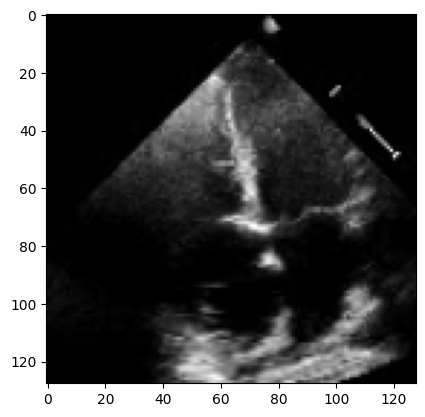

[[-0.6765668  -0.6765668  -0.6765668  ... -0.6765668  -0.6765668
  -0.6765668 ]
 [-0.6765668  -0.6765668  -0.6765668  ... -0.6765668  -0.6765668
  -0.6765668 ]
 [-0.6765668  -0.6765668  -0.6765668  ... -0.6765668  -0.6765668
  -0.6765668 ]
 ...
 [-0.6765668  -0.6765668  -0.6765668  ... -0.6554557  -0.6554557
  -0.6554557 ]
 [-0.6765668  -0.6765668  -0.6765668  ... -0.63434464 -0.6132336
  -0.6765668 ]
 [-0.6765668  -0.6765668  -0.6765668  ... -0.6765668  -0.6765668
  -0.6765668 ]]


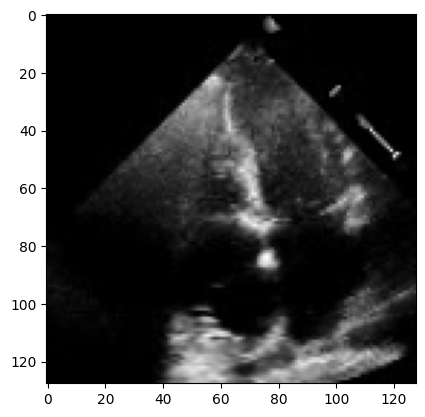

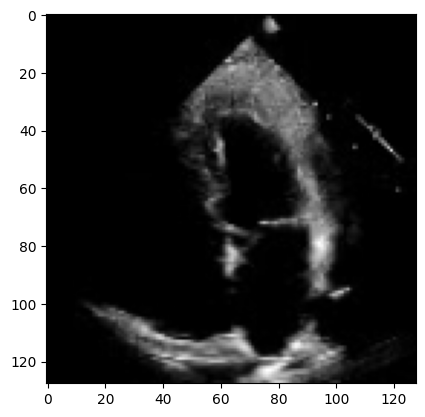

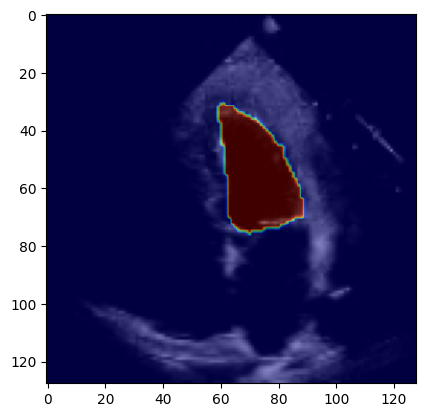

'\nmodel.train(False)\nlarge_frame = torch.from_numpy(large_frame).unsqueeze(0).to(device)\ny_large = model(large_frame)\n\nmodel2.to(device)\nmodel2.train(False)\ny_large2 = model2(large_frame)\n#plot the large frame\nplt.imshow(y_large[0, 0].detach().cpu().numpy(), cmap=\'gray\')\nplt.show()\n\nplt.imshow(y_large2["out"][0, 0].detach().cpu().numpy(), cmap=\'gray\')\nplt.show()\n'

In [10]:

#get the first image
image, target = train_dataset[1]

#plot the image
plt.imshow(image[0][15], cmap='gray')
plt.show()

print(target[0][2])
#plot the target
plt.imshow(target[0][2], cmap='gray')
plt.show()

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, num_workers=2, shuffle=False, pin_memory=False, collate_fn=_video_collate_fn)

(_, (large_frame, small_frame, large_trace, small_trace)) = dataloader.dataset[0]

#plot the large frame
plt.imshow(large_frame[0], cmap='gray')
plt.show()

#plot the large trace on top of the large frame
plt.imshow(large_frame[0], cmap='gray')
plt.imshow(large_trace, cmap='jet', alpha=0.5)
plt.show()
'''
model.train(False)
large_frame = torch.from_numpy(large_frame).unsqueeze(0).to(device)
y_large = model(large_frame)

model2.to(device)
model2.train(False)
y_large2 = model2(large_frame)
#plot the large frame
plt.imshow(y_large[0, 0].detach().cpu().numpy(), cmap='gray')
plt.show()

plt.imshow(y_large2["out"][0, 0].detach().cpu().numpy(), cmap='gray')
plt.show()
'''

In [3]:
import segmentation_models_pytorch as smp

modelSwinUnet = smp.Unet(
    encoder_name="tu-swin_tiny_patch4_window7_224",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    img_size = 128
)

# ✅ Check model output
dummy_input = torch.randn(1, 3, 128, 128).to(device)

modelSwinUnet = modelSwinUnet.to(device)
output = modelSwinUnet(dummy_input)

print("Output shape:", output.shape)  # Should match the adjusted feature map size

modelConvNet = smp.Unet(
    encoder_name="tu-convnextv2_tiny",
    #encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    #encoder_depth=3,
    #decoder_channels=(64, 32, 16)
)

# ✅ Check model output
modelConvNet = modelConvNet.to(device)
output = modelConvNet(dummy_input)
print("Output shape:", output.shape)  # Should match the adjusted feature map size

modelSwin2 = smp.Unet(
    encoder_name="tu-swinv2_tiny_window8_256",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    img_size = 128
)

# ✅ Check model output
modelSwin2 = modelSwin2.to(device)
output = modelSwin2(dummy_input)
print("Output shape:", output.shape)  # Should match the adjusted feature map size

modelDeepLabResNet = torchvision.models.segmentation.__dict__["deeplabv3_resnet50"](pretrained=False, aux_loss=False)


# ✅ Check model output
modelDeepLabResNet = modelDeepLabResNet.to(device)
output = modelDeepLabResNet(dummy_input)
print("Output shape:", output.shape)  # Should match the adjusted feature map size

c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\layers\interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


Output shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [4]:
#file_path
file_path = 'a4c-video-dir/'
N_EPOCHS = 20


In [ ]:

model_name = 'swin_tiny_patch4_window7_224'
#model = SwinDeepLabV3Plus().to(device)
run_segmentation(data_dir=file_path, model=modelSwinUnet, num_epochs=N_EPOCHS, model_name=model_name, output='output_swinUnet1', run_test=True, save_video=True)
#run_segmentation(data_dir=file_path, num_epochs=N_EPOCHS, output='output2', run_test=True, save_video=True, weights=None)


In [10]:
N_EPOCHS = 20
model_name = 'convnextv2_tiny'
#model = SwinDeepLabV3Plus().to(device)
run_segmentation(data_dir=file_path, model=modelConvNet, num_epochs=N_EPOCHS, model_name=model_name, output='output_ConvNextUnet', run_test=False, save_video=False)

100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


Epoch #0


C:\Users\samsc\AppData\Local\Temp\ipykernel_65404\1253971728.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(output, "checkpoint.p

Epoch #1


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.1160 (0.1150) / 0.3016 0.1318, 0.9092, 0.9328]


Epoch #2


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0710 (0.0628) / 0.3016 0.1318, 0.9137, 0.9306]


Epoch #3


100%|██████████| 65/65 [00:48<00:00,  1.33it/s, 0.0568 (0.0524) / 0.3016 0.1318, 0.9143, 0.9339]


Epoch #4


100%|██████████| 65/65 [00:46<00:00,  1.39it/s, 0.0462 (0.0601) / 0.3016 0.1318, 0.9025, 0.9242]


Epoch #5


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0428 (0.0461) / 0.3016 0.1318, 0.9098, 0.9250]


Epoch #6


100%|██████████| 65/65 [00:46<00:00,  1.39it/s, 0.0421 (0.0371) / 0.3016 0.1318, 0.9135, 0.9303]


Epoch #7


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0408 (0.0440) / 0.3016 0.1318, 0.9103, 0.9254]


Epoch #8


100%|██████████| 65/65 [00:48<00:00,  1.35it/s, 0.0422 (0.0528) / 0.3016 0.1318, 0.9132, 0.9249]


Epoch #9


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0422 (0.0392) / 0.3016 0.1318, 0.9099, 0.9280]


Epoch #10


100%|██████████| 65/65 [00:48<00:00,  1.33it/s, 0.0430 (0.0637) / 0.3016 0.1318, 0.9101, 0.9264]


Epoch #11


100%|██████████| 65/65 [00:46<00:00,  1.39it/s, 0.0451 (0.0492) / 0.3016 0.1318, 0.9026, 0.9208]


Epoch #12


100%|██████████| 65/65 [00:47<00:00,  1.37it/s, 0.0452 (0.0625) / 0.3016 0.1318, 0.9084, 0.9286]


Epoch #13


100%|██████████| 65/65 [00:47<00:00,  1.38it/s, 0.0466 (0.0423) / 0.3016 0.1318, 0.9099, 0.9286]


Epoch #14


100%|██████████| 65/65 [00:47<00:00,  1.37it/s, 0.0480 (0.0546) / 0.3016 0.1318, 0.9107, 0.9285]


Epoch #15


100%|██████████| 65/65 [00:48<00:00,  1.35it/s, 0.0483 (0.0299) / 0.3016 0.1318, 0.9104, 0.9254]


Epoch #16


100%|██████████| 65/65 [00:47<00:00,  1.38it/s, 0.0489 (0.0598) / 0.3016 0.1318, 0.9114, 0.9289]


Epoch #17


100%|██████████| 65/65 [00:48<00:00,  1.33it/s, 0.0504 (0.0461) / 0.3016 0.1318, 0.9102, 0.9259]


Epoch #18


100%|██████████| 65/65 [00:47<00:00,  1.37it/s, 0.0498 (0.0354) / 0.3016 0.1318, 0.9096, 0.9257]


Epoch #19


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0516 (0.0536) / 0.3016 0.1318, 0.9108, 0.9273]
C:\Users\samsc\AppData\Local\Temp\ipykernel_65404\1253971728.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

In [ ]:
model_name = 'tu-swinv2_tiny_window8_256'
#model = SwinDeepLabV3Plus().to(device)
run_segmentation(data_dir=file_path, model=modelSwin2, num_epochs=N_EPOCHS, model_name=model_name, output='output_SwinV2Unet', run_test=False, save_video=False)


100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


Epoch #0


C:\Users\samsc\AppData\Local\Temp\ipykernel_65404\1253971728.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(output, "checkpoint.p

Epoch #1


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0704 (0.0648) / 0.3016 0.1318, 0.9108, 0.9332]


Epoch #2


100%|██████████| 65/65 [00:48<00:00,  1.34it/s, 0.0518 (0.0429) / 0.3016 0.1318, 0.9120, 0.9313]


Epoch #3


100%|██████████| 65/65 [00:47<00:00,  1.37it/s, 0.0465 (0.0434) / 0.3016 0.1318, 0.9086, 0.9321]


Epoch #4


100%|██████████| 65/65 [00:46<00:00,  1.39it/s, 0.0410 (0.0546) / 0.3016 0.1318, 0.9004, 0.9196]


Epoch #5


100%|██████████| 65/65 [00:47<00:00,  1.38it/s, 0.0398 (0.0427) / 0.3016 0.1318, 0.9074, 0.9267]


Epoch #6


100%|██████████| 65/65 [00:48<00:00,  1.33it/s, 0.0390 (0.0376) / 0.3016 0.1318, 0.9111, 0.9301]


Epoch #7


100%|██████████| 65/65 [00:47<00:00,  1.38it/s, 0.0391 (0.0455) / 0.3016 0.1318, 0.9053, 0.9258]


Epoch #8


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0400 (0.0502) / 0.3016 0.1318, 0.9134, 0.9306]


Epoch #9


100%|██████████| 65/65 [00:49<00:00,  1.32it/s, 0.0407 (0.0341) / 0.3016 0.1318, 0.9070, 0.9243]


Epoch #10


100%|██████████| 65/65 [00:46<00:00,  1.39it/s, 0.0408 (0.0561) / 0.3016 0.1318, 0.9070, 0.9254]


Epoch #11


100%|██████████| 65/65 [00:47<00:00,  1.38it/s, 0.0422 (0.0384) / 0.3016 0.1318, 0.9053, 0.9240]


Epoch #12


100%|██████████| 65/65 [00:49<00:00,  1.30it/s, 0.0427 (0.0641) / 0.3016 0.1318, 0.9065, 0.9215]


Epoch #13


100%|██████████| 65/65 [00:48<00:00,  1.35it/s, 0.0432 (0.0388) / 0.3016 0.1318, 0.9071, 0.9269]


Epoch #14


100%|██████████| 65/65 [00:47<00:00,  1.37it/s, 0.0446 (0.0450) / 0.3016 0.1318, 0.9065, 0.9243]


Epoch #15


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0457 (0.0257) / 0.3016 0.1318, 0.9086, 0.9253]


Epoch #16


100%|██████████| 65/65 [00:48<00:00,  1.33it/s, 0.0454 (0.0547) / 0.3016 0.1318, 0.9104, 0.9287]


Epoch #17


100%|██████████| 65/65 [00:47<00:00,  1.37it/s, 0.0465 (0.0437) / 0.3016 0.1318, 0.9079, 0.9268]


Epoch #18


100%|██████████| 65/65 [00:47<00:00,  1.36it/s, 0.0469 (0.0329) / 0.3016 0.1318, 0.9087, 0.9270]


Epoch #19


100%|██████████| 65/65 [00:48<00:00,  1.34it/s, 0.0479 (0.0501) / 0.3016 0.1318, 0.9070, 0.9259]
C:\Users\samsc\AppData\Local\Temp\ipykernel_65404\1253971728.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

In [5]:
run_segmentation(data_dir=file_path,num_epochs=N_EPOCHS, output='outputOriginalModel', run_test=False, save_video=False)

100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


Epoch #0


C:\Users\samsc\AppData\Local\Temp\ipykernel_100608\921726061.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(output, "checkpoint.p

Epoch #1


100%|██████████| 65/65 [00:49<00:00,  1.31it/s, 0.0442 (0.0379) / 0.3016 0.1318, 0.8971, 0.9187]


Epoch #2


100%|██████████| 65/65 [00:50<00:00,  1.30it/s, 0.0392 (0.0394) / 0.3016 0.1318, 0.9100, 0.9254]


Epoch #3


100%|██████████| 65/65 [00:50<00:00,  1.29it/s, 0.0375 (0.0421) / 0.3016 0.1318, 0.9066, 0.9229]


Epoch #4


100%|██████████| 65/65 [00:51<00:00,  1.26it/s, 0.0367 (0.0413) / 0.3016 0.1318, 0.9062, 0.9230]


Epoch #5


100%|██████████| 65/65 [00:51<00:00,  1.26it/s, 0.0388 (0.0391) / 0.3016 0.1318, 0.9080, 0.9304]


Epoch #6


100%|██████████| 65/65 [00:49<00:00,  1.31it/s, 0.0389 (0.0376) / 0.3016 0.1318, 0.9037, 0.9224]


Epoch #7


100%|██████████| 65/65 [00:49<00:00,  1.31it/s, 0.0383 (0.0321) / 0.3016 0.1318, 0.9055, 0.9209]


Epoch #8


100%|██████████| 65/65 [00:49<00:00,  1.30it/s, 0.0415 (0.0401) / 0.3016 0.1318, 0.9049, 0.9223]


Epoch #9


100%|██████████| 65/65 [00:50<00:00,  1.28it/s, 0.0405 (0.0265) / 0.3016 0.1318, 0.9075, 0.9252]


Epoch #10


100%|██████████| 65/65 [00:50<00:00,  1.28it/s, 0.0422 (0.0983) / 0.3016 0.1318, 0.9049, 0.9207]


Epoch #11


100%|██████████| 65/65 [00:51<00:00,  1.26it/s, 0.0426 (0.0395) / 0.3016 0.1318, 0.9090, 0.9260]


Epoch #12


100%|██████████| 65/65 [00:50<00:00,  1.30it/s, 0.0442 (0.0340) / 0.3016 0.1318, 0.9054, 0.9217]


Epoch #13


100%|██████████| 65/65 [00:50<00:00,  1.29it/s, 0.0446 (0.0314) / 0.3016 0.1318, 0.9091, 0.9282]


Epoch #14


100%|██████████| 65/65 [00:51<00:00,  1.27it/s, 0.0448 (0.0379) / 0.3016 0.1318, 0.9091, 0.9281]


Epoch #15


100%|██████████| 65/65 [00:51<00:00,  1.26it/s, 0.0458 (0.0405) / 0.3016 0.1318, 0.9033, 0.9217]


Epoch #16


100%|██████████| 65/65 [00:49<00:00,  1.31it/s, 0.0461 (0.0665) / 0.3016 0.1318, 0.9119, 0.9289]


Epoch #17


100%|██████████| 65/65 [00:51<00:00,  1.27it/s, 0.0472 (0.0337) / 0.3016 0.1318, 0.9061, 0.9230]


Epoch #18


100%|██████████| 65/65 [00:50<00:00,  1.29it/s, 0.0467 (0.0410) / 0.3016 0.1318, 0.9108, 0.9311]


Epoch #19


100%|██████████| 65/65 [00:54<00:00,  1.19it/s, 0.0481 (0.0597) / 0.3016 0.1318, 0.9113, 0.9289]
C:\Users\samsc\AppData\Local\Temp\ipykernel_100608\921726061.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r